# Answering business questions with SQL 
The data Chinokk
case with the  Chinook database is a fictive database about a music store. 

We will use this dabatase and SQL language to answer different **business questions**:

#### 1.Selecting Albums to add to the shop collection:
the record label the shop has a agreement with proposed 4 new artists, the shop does not sell any songs form them yet.  The artists proposed are:
    - Regal	| Hip-Hop
    - Red Tone|	Punk
    - Meteor and the Girls|	Pop
    - Slim Jim Bites | Blues

The important part is: the record label is specialized in USA based artists and gave money to the shop for advirtisement. 



##  Loading the database

In [1]:
import sqlite3 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

- connection to the local database

In [2]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

## Overview of the data 

In [3]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ('table','view');

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


In [4]:
%%sql
SELECT
    billing_country country,
    SUM(total) total_per_country,          /* calcul $ per country */
    ROUND(SUM(total) / (SELECT SUM(total)  /* calcul %sales per country */
                        FROM invoice
                       )
                       *100,2) || '%'   share_per_country
FROM invoice 
GROUP BY country
ORDER BY total_per_country DESC

 * sqlite:///chinook.db
Done.


country,total_per_country,share_per_country
USA,1040.4899999999998,22.09%
Canada,535.5900000000001,11.37%
Brazil,427.68000000000006,9.08%
France,389.0699999999999,8.26%
Germany,334.62,7.11%
Czech Republic,273.24000000000007,5.8%
United Kingdom,245.52,5.21%
Portugal,185.13000000000002,3.93%
India,183.14999999999998,3.89%
Ireland,114.83999999999997,2.44%


In [5]:
sales_per_country = _.DataFrame()

In [6]:
#using the country col as index
sales_per_country.set_index('country', drop=True, inplace=True)

In [10]:
sales_per_country['share_per_country'] = sales_per_country['share_per_country'].str.replace('%','').astype(float)

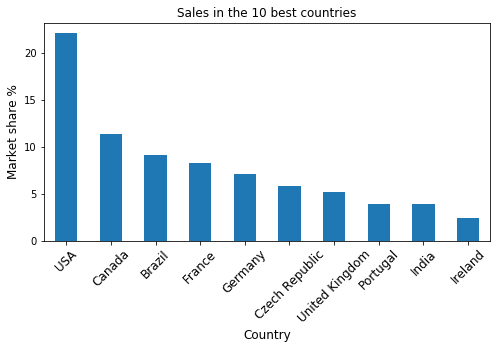

In [23]:
sales_per_country['share_per_country'].head(10).plot.bar(figsize=(8,4))
plt.xticks(rotation=45,size=12)
plt.ylabel('Market share %',size=12)
plt.xlabel('Country',size=12)
plt.title('Sales in the 10 best countries')
plt.savefig('tot_sales_per_country.jpg')

The USA represents more that 1/5 of the total sales of the disc shope hence it is important to nurture it by introducing new albums.

## 1.Selecting Albums to add to the shop collection:
The four new artists are from different music style. In order to select the one with the best chance to be sold we need to analyze what music genres sell well in USA. so in the next block we will:

- isolated the sells in USA 
- find the trakcs corresponds to these invoices in USA
- find the genre of each tracks
- then compute the numbers of each genres sold 

- BUT a good info is to know also how much we sold in total for each genre (maybe a niche group where people are ready to spend more money)

- extract only the bills from USA
We create some views in the SQL dabatase as it might serve us also later.

In [24]:
%%sql
CREATE VIEW billing_usa AS
    SELECT * 
    FROM invoice
    WHERE billing_country='USA'

 * sqlite:///chinook.db
Done.


[]

- merging the info about the genre of the tracks founds in the bills from USA

In [25]:
%%sql
CREATE VIEW usa_track_genre AS
    SELECT
        il.invoice_id,
        il.invoice_line_id,
        track.name track_name,
        il.quantity track_quantity,
        il.unit_price,
        genre.name genre_name
           
    FROM billing_usa
    INNER JOIN invoice_line il ON billing_usa.invoice_id = il.invoice_id
    INNER JOIN track ON track.track_id = il.track_id
    inner JOIN genre ON genre.genre_id = track.genre_id

 * sqlite:///chinook.db
Done.


[]

-  finally counts the total sales per music genre in USA

In [52]:
%%sql
SELECT 
    genre_name,
    COUNT(genre_name) quantity,
    CAST(COUNT(genre_name) as float)/(SELECT sum(track_quantity)
                                      FROM usa_track_genre)
         *100 || '%' per_sales
FROM usa_track_genre
GROUP BY genre_name
ORDER BY quantity DESC;

 * sqlite:///chinook.db
Done.


genre_name,quantity,per_sales
Rock,561,53.37773549000951
Alternative & Punk,130,12.369172216936251
Metal,124,11.798287345385347
R&B/Soul,53,5.042816365366318
Blues,36,3.425309229305423
Alternative,35,3.3301617507136063
Pop,22,2.093244529019981
Latin,22,2.093244529019981
Hip Hop/Rap,20,1.9029495718363463
Jazz,14,1.3320647002854424


In [67]:
#put the data into a DataFrame
sales_genre_usa.index = ['Rock', 'Alt & Punk', 'Metal', 'R&B/Soul', 'Blues',
       'Alternative', 'Pop', 'Latin', 'Hip Hop/Rap', 'Jazz', 'Easy Listening',
       'Reggae', 'Electronica/Dance', 'Classical', 'Heavy Metal', 'Soundtrack',
       'TV Shows']

In [68]:
sales_genre_usa.set_index('genre_name',drop=True,inplace=True)

KeyError: "None of ['genre_name'] are in the columns"

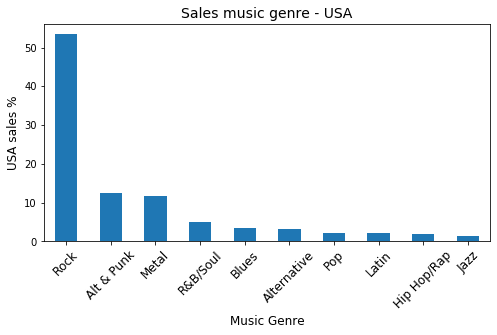

In [73]:
sales_genre_usa['per_sales'].head(10).plot.bar(figsize=(8,4))
plt.xticks(rotation=45,size=12)
plt.ylabel('USA sales %',size=12)
plt.xlabel('Music Genre',size=12)
plt.title('Sales music genre - USA',size=14)
plt.savefig('sales_music_genre_usa.jpg')

- More than 50% of the sales in USA is rock music.
- Based on these data,  among the 4 artists proposed by the record label I would recommend:
    - Red Tone (Punk)
    - Slim Jim Bites (Blues)
    - Metor and the Girls (Pop)
- to be notice the pop and blues genres follow in ranking so the choice of one over the other should be decided on another metrics
    

### Analyzing Employee Sales Performance  

In [ ]:
%%sql 

SELECT 
    e.first_name ||' '|| e.last_name employee_name,
    SUM(i.total) total_sold,
    e.hire_date hiring_date,
    e.title,
    e.birthdate birthdate, 
    e.country country
FROM invoice i
INNER JOIN customer c on c.customer_id = i.customer_id
INNER join employee e on e.employee_id = c.support_rep_id
GROUP BY c.support_rep_id
ORDER BY total_sold DESC;

In [ ]:
%%sql 

SELECT 
    e.first_name ||' '|| e.last_name employee_name,
    SUM(billing_USA.total) total_sold,
    e.hire_date hiring_date,
    e.title,
    e.birthdate birthdate, 
    e.country country
FROM billing_USA 
INNER JOIN customer c on c.customer_id = billing_USA.customer_id
INNER join employee e on e.employee_id = c.support_rep_id
GROUP BY c.support_rep_id
ORDER BY total_sold DESC;

- there are only 3 employees responsible for the selling support
- the total sold per employee correlates with their date of arrival at the compagny so it makes senses
- the age does not seem to matter for the selling ranking
- if we take a closer looker at USA selling report, the ranking is really different, so it might that each seller specialised in a number of country and even maybe in different music Genres, so are they specialsed ? it should be checking

##  Analyzing Sales by Country
to the contrary of the first cells of this jupyter we will focus on the country of the customers and not of the billing

 => for more help on understand the *where country = c.country* go https://community.dataquest.io/t/191-5-answering-business-questions-using-sql/8894/2

In [ ]:
%%sql

WITH other_or_country AS 
    (SELECT
     CASE
             WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                   ) = 1 THEN "Other"
             ELSE c.country
     END AS country,
     c.customer_id,
     il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT *

FROM other_or_country
limit 5

In [ ]:
%%sql

WITH other_or_country AS 
    (SELECT
     CASE
             WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                   ) = 1 THEN "Other"
             ELSE c.country
     END AS country,
     c.customer_id,
     il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

    
SELECT
    COUNTRY,
    number_customers,
    ROUND(total_sales,2) total_sales,
    ROUND(average_per_order,2) average_per_order,
    ROUND(average_sales_per_customer,2)average_sales_per_customer
FROM (SELECT
        COUNTRY,
        COUNT(DISTINCT(customer_id)) number_customers,
        SUM(unit_price) total_sales,
        COUNT(DISTINCT(invoice_id)) number_order,
        SUM(unit_price) / COUNT(DISTINCT(invoice_id)) average_per_order,
        SUM(unit_price) / COUNT(DISTINCT(customer_id)) average_sales_per_customer,
        CASE 
            WHEN country = 'Other' THEN 0
            ELSE 1
        END AS ord
        FROM other_or_country
        GROUP BY country
        order by ord DESC, total_sales DESC
      )
    

###  Albums vs Indidual Tracks

The request:

Write a query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:
Number of invoicesm
Percentage of invoices

I did not use the same method as proposed in the solution https://github.com/dataquestio/solutions/blob/master/Mission191Solutions.ipynb 

I think what I have done is simplier to write :

    1- one subquery: group the invoice_line database by invoice_id & by album_id and add the number of tracks bought from each  album. 
    2- one subquery: group the track database by album and add the number of tracks on the album
    3- left join the album_db to the invoice_db on the album_id 
    4- create a binary if the selling of for each album was a full album by comparing the number of tracks for each albums in each invoice vs the normal number of tracks
    5- group again by invoice_id and sum the number of album per invoice
    6- conclude

In [ ]:
%%sql 
WITH invoices_album_tracks_sold AS
    (
    SELECT 
        invoice_id,
        album_id,
        COUNT(t.track_id) number_tracks_sold
    FROM invoice_line il
    INNER JOIN track t on t.track_id = il.track_id 
    GROUP BY invoice_id, album_id
    ),

albums_tracks_info AS
    (
    SELECT 
        album_id,
        count(track_id) track_on_cd
    from track
    GROUP BY album_id  
    ),

invoices_with_full_album AS
    (
    SELECT 
    invoice_id,
    iats.album_id,
    CASE 
        WHEN (iats.number_tracks_sold = ati.track_on_cd and ati.track_on_cd > 2) THEN 1
        ELSE 0
        END AS full_album_sold
    FROM invoices_album_tracks_sold iats
    LEFT JOIN albums_tracks_info ati ON ati.album_id = iats.album_id
    ),
    
unique_invoice_id_albums_sold AS
    (
    SELECT 
        invoice_id,
        SUM(full_album_sold) album_sold
    FROM invoices_with_full_album
    GROUP BY invoice_id
    )

SELECT
    COUNT(invoice_id) number_invoices,
    SUM(album_sold) invoice_with_album_sold,
    SUM(album_sold)/CAST(COUNT(invoice_id) as float) per_invoices_with_album
FROM unique_invoice_id_albums_sold

Conclusion 18% of all the invoices includes at least one album (some with more tracks in addition), so it would be a bad move to not propose to the clients to buy the full albums.

####  To go further
If you'd like more practice, you can look at the schema and come up with some more business questions, and then write queries to answer them. Here are a few to get you started:

- Which artist is used in the most playlists?
- How many tracks have been purchased vs not purchased?
- Is the range of tracks in the store reflective of their sales popularity?
- Do protected vs non-protected media types have an effect on popularity?

Link schematic Chinook database: https://s3.amazonaws.com/dq-content/189/chinook-schema.svg